# Task 1

## Import Tenserflow

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


# 1a) Flowers

In [2]:
import IPython.display as display
import matplotlib.pyplot as plt
import random
import time

from tensorflow.keras import datasets, layers, models

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 192
SHUFFLE_SIZE = 1000

## Download the flowers from dataset

In [3]:
import pathlib
data_root_orig = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_root = pathlib.Path(data_root_orig)
print(data_root)

228813984/228813984 [==============================] - 2s 0us/step
/root/.keras/datasets/flower_photos


## Write an input pipeline from scratch

In [4]:
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

3670

In [5]:
all_image_paths[:5]

['/root/.keras/datasets/flower_photos/tulips/12916135413_dafcf3089e_n.jpg',
 '/root/.keras/datasets/flower_photos/daisy/8932490012_cc08e690ba_n.jpg',
 '/root/.keras/datasets/flower_photos/tulips/16751015081_af2ef77c9a_n.jpg',
 '/root/.keras/datasets/flower_photos/tulips/3502632842_791dd4be18_n.jpg',
 '/root/.keras/datasets/flower_photos/sunflowers/9484354480_07ff2ef0a6.jpg']

## Get to know your data

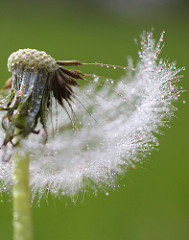

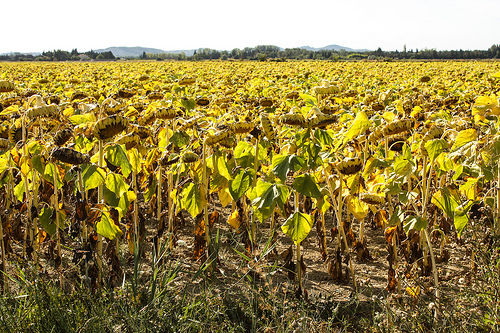

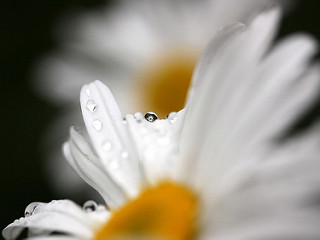

In [6]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print()

## Classes are given by directory names

In [7]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [8]:
label_to_index = dict((name, index) for index, name in enumerate(label_names))
label_to_index

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [9]:
all_labels = [label_to_index[pathlib.Path(path).parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_labels[:10])

First 10 labels indices:  [4, 0, 4, 4, 3, 3, 2, 3, 1, 1]


## Create a train/test split

In [10]:
from sklearn.model_selection import train_test_split
train_paths, test_paths, train_labels, test_labels = train_test_split(all_image_paths, all_labels)

## Display a few images and their labels

daisy


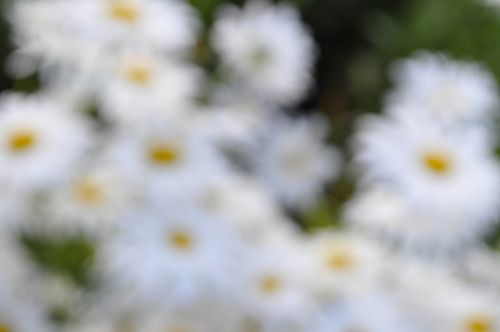


sunflowers


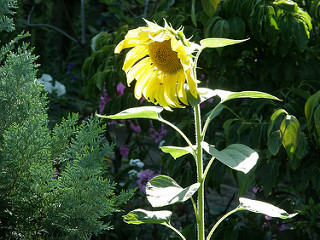


daisy


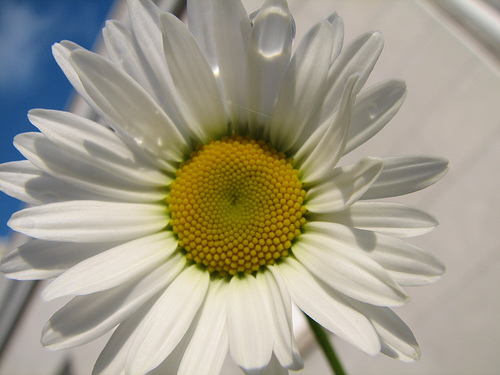

In [11]:
for n in range(3):
  i = random.randint(0,len(train_paths))
  image_path = train_paths[i]
  print(label_names[train_labels[i]])
  display.display(display.Image(image_path))
  print()

## Begin using TensorFlow ops to read and decode the images

In [12]:
img_raw = tf.io.read_file(train_paths[0])
print(repr(img_raw)[:100]+"...")

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00...


In [13]:
img_tensor = tf.image.decode_image(img_raw)
print(img_tensor.shape)
print(img_tensor.dtype)

(240, 240, 3)
<dtype: 'uint8'>


In [14]:
img_final = tf.image.resize(img_tensor, [IMG_SIZE, IMG_SIZE])
img_final = img_final / 255.0 # normalize pixel values
print(img_final.shape)
print(img_final.numpy().min())
print(img_final.numpy().max())

(192, 192, 3)
0.0
0.99718136


## Wrap those in a function

In [15]:
def load_and_preprocess_image(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  img /= 255.0  # normalize pixels to 0,1
  return img

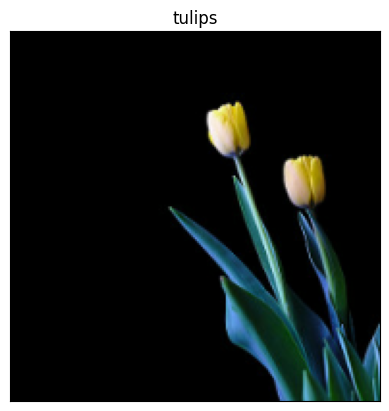

In [16]:
def show(img, label):
  plt.imshow(img)
  plt.title(label)
  plt.xticks([])
  plt.yticks([])
  print()

img_path = train_paths[0]
img = load_and_preprocess_image(img_path)
label = label_names[train_labels[0]]
show(img, label)

## Build an input pipeline to return images and labels

In [17]:
# a dataset that returns image paths
path_ds = tf.data.Dataset.from_tensor_slices(train_paths)
for n, img_path in enumerate(path_ds.take(4)):
  print(n, img_path)

0 tf.Tensor(b'/root/.keras/datasets/flower_photos/tulips/12764617214_12211c6a0c_m.jpg', shape=(), dtype=string)
1 tf.Tensor(b'/root/.keras/datasets/flower_photos/sunflowers/3146795631_d062f233c1.jpg', shape=(), dtype=string)
2 tf.Tensor(b'/root/.keras/datasets/flower_photos/roses/3276552939_8c31b22d3e.jpg', shape=(), dtype=string)
3 tf.Tensor(b'/root/.keras/datasets/flower_photos/tulips/14836105101_1d07520932_m.jpg', shape=(), dtype=string)


In [18]:
# a dataset that returns images (loaded off disk, decoded, and preprocessed)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
for n, image in enumerate(image_ds.take(4)):
  print(n, image.shape)

0 (192, 192, 3)
1 (192, 192, 3)
2 (192, 192, 3)
3 (192, 192, 3)


In [19]:
# a dataset that returns labels
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_labels, tf.int64))
for label in label_ds.take(4):
  print(label_names[label.numpy()])

tulips
sunflowers
roses
tulips


In [20]:
# a dataset that returns images and labels
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
print(image_label_ds)

<_ZipDataset element_spec=(TensorSpec(shape=(192, 192, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


In [21]:
for img, label in image_label_ds.take(2):
  print(img.shape, label_names[label.numpy()])

(192, 192, 3) tulips
(192, 192, 3) sunflowers


## Batch and shuffle

In [22]:
ds = image_label_ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

for img, label in ds.take(2):
  print(img.shape, label.shape) # notice it's returning batches of data now

(32, 192, 192, 3) (32,)
(32, 192, 192, 3) (32,)


## Improve performance

In [23]:
# A benchmark utility to time how long it takes
# to iterate once over the entire dataset
def time_one_epoch(ds):
  start = time.time()
  batches = 0
  for i,(images,labels) in enumerate(ds):
    batches += 1
    if i % 10 == 0:
      print('.', end='')
  print()
  end = time.time()
  duration = end-start
  print("Read {} batches".format(batches))
  print("{:0.2f} Batches/s".format(batches/duration))
  print("{:0.2f} Images/s".format(BATCH_SIZE*batches/duration))
  print("Total time: {}s".format(duration))

## Use in-memory caching

In [24]:
ds = image_label_ds.cache() # cache data in mempry
ds = ds.shuffle(SHUFFLE_SIZE)
ds = ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [25]:
time_one_epoch(ds) # this will be slow

.........
Read 86 batches
17.10 Batches/s
547.11 Images/s
Total time: 5.030040979385376s


In [26]:
time_one_epoch(ds) # this will be fast

.........
Read 86 batches
133.70 Batches/s
4278.41 Images/s
Total time: 0.6432301998138428s


## How to use in-disk caching

In [27]:
# here's our final training dataset
train_ds = image_label_ds.cache()
train_ds = train_ds.shuffle(SHUFFLE_SIZE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# let's make a test dataset as well
path_ds = tf.data.Dataset.from_tensor_slices(test_paths)
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_labels, tf.int64))
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))
test_ds = image_label_ds.cache().batch(BATCH_SIZE)

# 1b) Create a simple CNN

In [28]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu',
                        input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 190, 190, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 95, 95, 16)        0         
 D)                                                              
                                                                 
Total params: 448 (1.75 KB)
Trainable params: 448 (1.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

In [31]:
model.add(layers.Flatten())
model.add(layers.Dense(5, activation='softmax'))

In [32]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
86/86 [==============================] - 63s 701ms/step - loss: 1.6273 - accuracy: 0.1962 - val_loss: 1.6228 - val_accuracy: 0.1863
Epoch 2/5
86/86 [==============================] - 50s 577ms/step - loss: 1.6142 - accuracy: 0.1919 - val_loss: 1.6110 - val_accuracy: 0.1863
Epoch 3/5
86/86 [==============================] - 53s 613ms/step - loss: 1.6071 - accuracy: 0.2445 - val_loss: 1.6048 - val_accuracy: 0.2473
Epoch 4/5
86/86 [==============================] - 62s 722ms/step - loss: 1.6036 - accuracy: 0.2438 - val_loss: 1.6017 - val_accuracy: 0.2473
Epoch 5/5
86/86 [==============================] - 54s 625ms/step - loss: 1.6022 - accuracy: 0.2438 - val_loss: 1.6001 - val_accuracy: 0.2473


## Make predictions on a single image


In [34]:
img_index = 0
img = load_and_preprocess_image(train_paths[img_index])

im_batch = tf.expand_dims(img, axis=0)

# After adding the batch dimension, the shape will be (1, 192, 192, 3)
print(im_batch.shape)  # after

# make predictions
batch_pred = model.predict(im_batch)  # returns a list of predictions
pred = batch_pred[0]

print("Prediction", label_names[tf.argmax(pred)])
print("Actual", label_names[train_labels[img_index]])

(1, 192, 192, 3)
1/1 [==============================] - 0s 109ms/step
Prediction dandelion
Actual tulips


### Improving accuracy

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 190, 190, 32)      896       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 95, 95, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 93, 93, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 44, 44, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 22, 22, 128)      

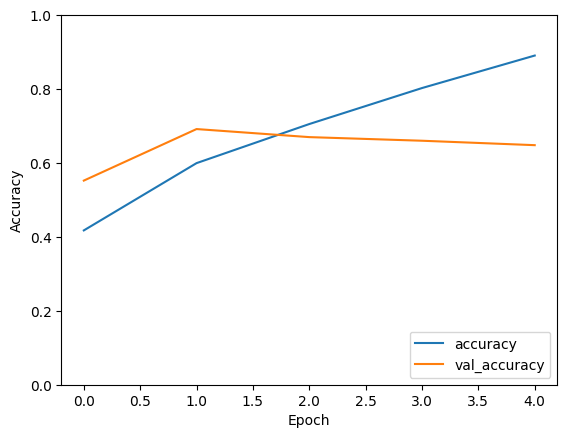

In [35]:
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

# Model summary
model.summary()

# Model compilation
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model training
history = model.fit(train_ds, validation_data=test_ds, epochs=5)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

## 1c) Practice deploying your flowers classifier using TensorFlow.js

In [41]:
model.save("/content/my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
!ls -lha

total 92M
drwxr-xr-x 1 root root 4.0K Feb 11 12:10 .
drwxr-xr-x 1 root root 4.0K Feb 11 11:42 ..
drwxr-xr-x 4 root root 4.0K Feb  8 14:20 .config
-rw-r--r-- 1 root root  92M Feb 11 12:10 my_model.h5
drwxr-xr-x 1 root root 4.0K Feb  8 14:21 sample_data


## 1d) Classify flowers using transfer learning

In [51]:
!pip install tensorflowjs
from tensorflow.keras.models import load_model
import tensorflowjs as tfjs

# Load your Keras model from the .h5 file
keras_model = load_model('my_model.h5')

# Convert the Keras model to TensorFlow.js format
tfjs.converters.save_keras_model(keras_model, 'tfjs_model')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 47.5 MB/s eta 0:00:00


In [43]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [44]:
# A hack to show you the output shape of the model
for image_batch, label_batch in train_ds.take(1):
   pass

feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 6, 6, 1280)


In [45]:
# do not update the pretrained weights during training
# (we won't use finetuning here)
base_model.trainable = False

In [46]:
base_model.summary()

Model: "mobilenetv2_1.00_192"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 192, 192, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 96, 96, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 96, 96, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 96, 96, 32)           0         ['bn_Conv1[

In [47]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(5, activation='softmax')

In [48]:
# build a new model reusing the pretrained base
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [49]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [50]:
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
86/86 [==============================] - 101s 1s/step - loss: 0.7527 - accuracy: 0.7220 - val_loss: 0.4699 - val_accuracy: 0.8508
Epoch 2/5
86/86 [==============================] - 97s 1s/step - loss: 0.3847 - accuracy: 0.8721 - val_loss: 0.3879 - val_accuracy: 0.8780
Epoch 3/5
86/86 [==============================] - 110s 1s/step - loss: 0.3033 - accuracy: 0.8983 - val_loss: 0.3785 - val_accuracy: 0.8824
Epoch 4/5
86/86 [==============================] - 112s 1s/step - loss: 0.2525 - accuracy: 0.9179 - val_loss: 0.3421 - val_accuracy: 0.8987
Epoch 5/5
86/86 [==============================] - 115s 1s/step - loss: 0.2155 - accuracy: 0.9342 - val_loss: 0.3366 - val_accuracy: 0.8965


# 2a) Collect your own dataset and train a model on it

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive
IMG_SIZE = 224

drive.mount('/content/drive')

data_root = r'/content/drive/My Drive/MyPhotosForModel'

# Creating Data Generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    data_root,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Model definition
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Model compilation
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model training
model.fit(train_generator, epochs=10)

# Model saving
model.save('/content/drive/My Drive/MyPhotosForModel/my_model.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 300 images belonging to 3 classes.
Epoch 1/10
10/10 [==============================] - 83s 7s/step - loss: 1.1583 - accuracy: 0.4433
Epoch 2/10
10/10 [==============================] - 63s 6s/step - loss: 0.9680 - accuracy: 0.4833
Epoch 3/10
10/10 [==============================] - 64s 6s/step - loss: 0.4820 - accuracy: 0.8700
Epoch 4/10
10/10 [==============================] - 64s 6s/step - loss: 0.2937 - accuracy: 0.9100
Epoch 5/10
10/10 [==============================] - 64s 6s/step - loss: 0.2958 - accuracy: 0.8800
Epoch 6/10
10/10 [==============================] - 64s 6s/step - loss: 0.3511 - accuracy: 0.8667
Epoch 7/10
10/10 [==============================] - 68s 6s/step - loss: 0.2099 - accuracy: 0.9267
Epoch 8/10
10/10 [==============================] - 63s 6s/step - loss: 0.1199 - accuracy: 0.9600
Epoch 9/10
10/10 [============================

In [54]:
!pip install tensorflowjs
from tensorflow.keras.models import load_model
import tensorflowjs as tfjs

# Load your Keras model from the .h5 file
keras_model = load_model('drive/My Drive/MyPhotosForModel/my_model.h5')

# Convert the Keras model to TensorFlow.js format
tfjs.converters.save_keras_model(keras_model, 'drive/My Drive/MyPhotosForModel/tfjs_model')